# Future Impact of Ocean Acidification on Coral Reefs in the Great Barrier Reef

In [51]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
sns.set()

In [52]:
def plot_regression(x, y, x_f=None, y_f=None, title='', xlabel='', ylabel=''):
    """
    Creates scatter plot with linear regression model, plots predicted points if passed in
    
    Args:
        x (np.array): true x data
        y (np.array): true y data
        x_f (np.array): predicted x data (default=None)
        y_f (np.array): predicted y data (default=None)
        title (str): title of the plot
    Returns:
        intercept, coef (float, float): intercept and coef of the linear regression
    """
    
    reg = LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)

    # compute mean squared error
    mse = ((y_pred - y) ** 2).mean()
    r2 = r2_score(y_true=y, y_pred=y_pred)

    # plot it
    plt.scatter(x, y, label='observed')
    plt.plot(x, y_pred, label='model (regression)')
        
    if x_f is not None and y_f is not None:
        plt.scatter(x_f, y_f, label='predicted')
        
    plt.legend()

    sns.set(font_scale=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gcf().set_size_inches(10, 5)
    plt.gca().title.set_text(title)

    # print model   
    intercept = reg.intercept_
    coef = reg.coef_[0]
    model_str = f'y = {intercept} + '
    model_str += f'{coef} x'
    
    return (intercept, coef)

## Predicting CO2

Steps for predicting CO2:
1. Get the CO2 dataframe (do not exclude values past 2004, since we need these to predict future values)
2. Call plot_regression() to visualize this data and get linear regression model
3. Predict CO2 emissions up to 2050 using this linear regression model and add data to df_co2_predicted
4. Call plot_regression again to visualize old data and predicted data
5. Combine df_co2 with df_co2_predicted into df_co2_future. This can now be used to predict pH.

In [3]:
def get_australia_co2(trim_year=False):
    """Gets and cleans historic carbon emmissions data of Autralia into a DataFrame
    
    Args:
        trim_year (bool): do we want to exclude data not within 1959-2004? (default=False)
    
    Returns:
        df_co2 (DataFrame) : DataFrame containing the cleaned carbon emissions data
    """
    df_co2 = pd.read_csv('National_Carbon_Emissions_2020v1.0.csv')
    
    # Set columns to row 10
    df_co2.columns = df_co2.iloc[10]
    
    # remove all rows before row 10
    for index in df_co2.index:
        if index < 10:
            df_co2.drop(index, inplace=True)
            
    # Name the year column and delete nan values
    df_co2.rename(columns={df_co2.columns[0]:'Year'}, inplace=True)
    df_co2 = df_co2[df_co2['Year'].notna()]
    
    # Convert years to ints
    df_co2['Year'] = pd.to_numeric(df_co2['Year'])
    
    if trim_year:
        # we don't want data past 2004
        bool_series = df_co2['Year'] <= 2004
        df_co2 = df_co2.loc[bool_series, :]
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_co2.set_index(['Year'], inplace=True)
    
    
    # only use Australia's co2 emissions
    df_co2 = df_co2.loc[:, df_co2.columns == 'Australia']
    df_co2.rename(columns={df_co2.columns[0]:'CO2 emissions (MtC)'}, inplace=True)   
    df_co2['CO2 emissions (MtC)'] = pd.to_numeric(df_co2['CO2 emissions (MtC)'])

    
    return df_co2

df_co2 = get_australia_co2()
df_co2.head()

10,CO2 emissions (MtC)
Year,
1959,23
1960,24
1961,25
1962,26
1963,28


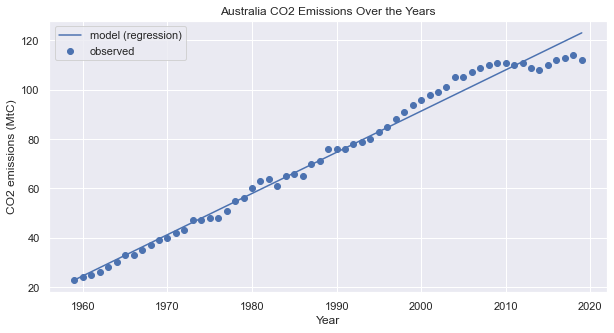

In [53]:
x = df_co2.index.astype('Int64').values
x = x.reshape((-1, 1))
y_feat = 'CO2 emissions (MtC)'
y = df_co2[y_feat]

intercept, coef = plot_regression(x, y, title='Australia CO2 Emissions Over the Years', xlabel='Year', ylabel=y_feat)

Formula for predicting CO2 emissions (y) for given year (x): y = -3247.941671073506 + 1.6696456901110523 x

In [5]:
# predict until 2050

df_co2_predicted = pd.DataFrame(columns = ['Year', y_feat])
df_co2_predicted.set_index('Year', inplace=True)

for i in range(2020, 2051):
    formula = intercept + coef * i
    df_co2_predicted.loc[i] = [formula]

df_co2_predicted.head()

,CO2 emissions (MtC)
Year,
2020,124.742623
2021,126.412269
2022,128.081914
2023,129.751560
2024,131.421206


(-3247.941671073506, 1.6696456901110523)

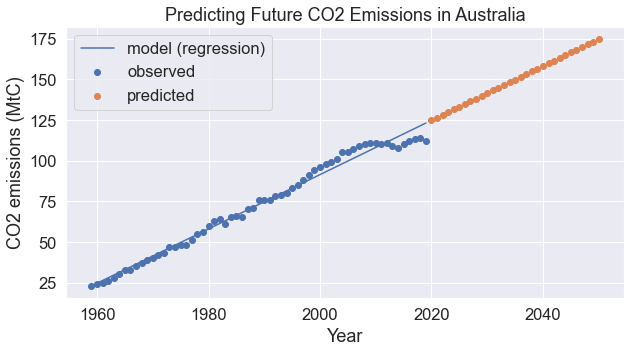

In [54]:
x_f = df_co2_predicted.index.astype('Int64').values
y_f = df_co2_predicted[y_feat]
plot_regression(x, y, x_f, y_f, title='Predicting Future CO2 Emissions in Australia', xlabel='Year', ylabel=y_feat)

In [7]:
# add predicted values to df_co2
df_co2_future = pd.concat([df_co2, df_co2_predicted])

df_co2_future

10,CO2 emissions (MtC)
Year,
1959,23.000000
1960,24.000000
1961,25.000000
1962,26.000000
1963,28.000000
...,...
2046,168.153411
2047,169.823057
2048,171.492702


## Predicting pH

Steps for predicting pH:
1. Create ```df_ph_co2``` with pH data (1959 - 2004) and previously constructed ```df_co2``` via ```get_ph_and_co2()```.
2. Rename dataframe as ```df_ph_co2_mean``` and add additional column to represent the average of the previous 5 years' pH levels via ```create_prev_mean()```.
3. Calculate linear regression model and visualize.
4. Predict pH emissions up to 2050 using this linear regression model and add data to ```df_ph_predicted```.
5. Plot and visualize predicted regression linear against observed samples.
6. Extract year and pH information from ```df_ph_predicted``` into ```df_ph_future``` which can now be used to predict coral calcification.

In [8]:
def get_ph_and_co2(df_co2):
    """ Gets pH information and creates combined dataframe with historical co2
    
    Args:
        df_co2 (pd.DataFrame) : dataframe of past future co2 emissions until 2004
    
    Returns:
        df_ph_co2 (pd.DataFrame): dataframe of past 
    """
    df_ph_co2 = pd.read_csv('arlington2009.csv')
    df_ph_co2.dropna(inplace=True)

    # remove unimportant columns
    del df_ph_co2['SampleID']
    del df_ph_co2['        d13C (per mil VPDB) *c']
    del df_ph_co2['        d18O (per mil VPDB) *c']
    del df_ph_co2['        d11B (per mil) *d']
    del df_ph_co2['2sigma']
    del df_ph_co2['   2sigma mean *e']
    del df_ph_co2['      Mg/Ca (x10-3) *b']
    del df_ph_co2['       Sr/Ca (x10-3) *b']
    del df_ph_co2['      Ba/Ca (x10-6)  *b']
    df_ph_co2.columns = ['Year', 'pH']
    
    
    bool_series = df_ph_co2['Year'] >= 1959
    df_ph_co2 = df_ph_co2.loc[bool_series, :]
    
    bool_series = df_ph_co2['Year'] <= 2004
    df_ph_co2 = df_ph_co2.loc[bool_series, :]
    
    # append co2 dataframe to get combined info (both pH and co2)
    df_co2.reset_index(inplace=True)
    df_ph_co2 = pd.merge(df_ph_co2, df_co2, on='Year', how='outer')
    df_ph_co2 = df_ph_co2.astype({"Year": int})
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_ph_co2.set_index(['Year'], inplace=True)
    

    return df_ph_co2

    
df_ph_co2 = get_ph_and_co2(get_australia_co2(True))
df_ph_co2.head()

,pH,CO2 emissions (MtC)
Year,,
1959,7.94,23
1960,8.01,24
1961,7.94,25
1962,7.90,26
1963,7.95,28


In [9]:
def create_prev_mean(df_ph_co2):
    """alters given dataframe by adding new "mean" column that represents the mean of previous 5 years' values
    
    Args:
        df_ph_co2 (pd.DataFrame) : dataframe of pH and CO2 emissions per year (1959 - 2004)
                                    * year is not index, reset index before using method *
    
    Returns:
        df_ph_co2_mean (pd.DataFrame) : dataframe altered with new "mean" for pH col
    """

    df_ph_co2_mean = pd.DataFrame(columns = ['Year', 'pH', 'CO2 emissions (MtC)', 'pH mean'])
    df_ph_co2_mean.set_index('Year', inplace=True)    
    year_list = df_ph_co2.index.unique()
    
    for i, year in enumerate(year_list):
        
        # years less than 5 are weird because they don't prev 5 years' data, so take mean of available years
        if i < 5:
            ph_sum = 0
            co2_sum = 0
            
            # if this is the very first entry, we just set the mean to current entry
            if i == 0:
                ph_mean = df_ph_co2.iloc[i, :]['pH']
            else:
                for idx in range(0, i):

                    # year = index 0
                    # pH = index 1
                    # co2 = index 2
                    data = df_ph_co2.iloc[idx, :]
                    ph_sum += data['pH']

                ph_mean = ph_sum / i
                    
        else:
            ph_sum = 0
            # the 5 previous years
            for idx in range(i - 5, i):
                
                data = df_ph_co2.iloc[idx, :]
                ph_sum += data['pH']
            
            ph_mean = ph_sum / 5
        
        df_ph_co2_mean.loc[year] = [df_ph_co2.loc[year]['pH'], df_ph_co2.loc[year]['CO2 emissions (MtC)'], ph_mean]

    
    return df_ph_co2_mean

In [10]:
df_ph_co2_mean = create_prev_mean(df_ph_co2)
df_ph_co2_mean.head()

,pH,CO2 emissions (MtC),pH mean
Year,,,
1959,7.94,23.0,7.940000
1960,8.01,24.0,7.940000
1961,7.94,25.0,7.975000
1962,7.90,26.0,7.963333
1963,7.95,28.0,7.947500


In [12]:
df_ph_co2_mean = df_ph_co2_mean.reset_index()

In [13]:
# initialize regression object
reg = LinearRegression()
x_feat_list = ['Year', 'CO2 emissions (MtC)', 'pH mean']
y_feat = 'pH'

# get target variable
x = df_ph_co2_mean.loc[:, x_feat_list].values
y = df_ph_co2_mean.loc[:, y_feat].values
    
# fit regression
reg.fit(x, y)

# compute / store r2
y_pred = reg.predict(x)
    
# print model
model_str = y_feat + f' = {reg.intercept_}'
for feat, coef in zip(x_feat_list, reg.coef_):
    model_str += f' + {coef} {feat}'
print('Formula for prediciting pH level of Australian seawater: \n' + model_str)

# compute r2
r2 = r2_score(y_true=y, y_pred=y_pred)
print(f'r2 = {r2:.3}')

Formula for prediciting pH level of Australian seawater: 
pH = -89.33875472455281 + 0.0521363467490728 Year + -0.032095554397400985 CO2 emissions (MtC) + -0.5109060057159558 pH mean
r2 = 0.347


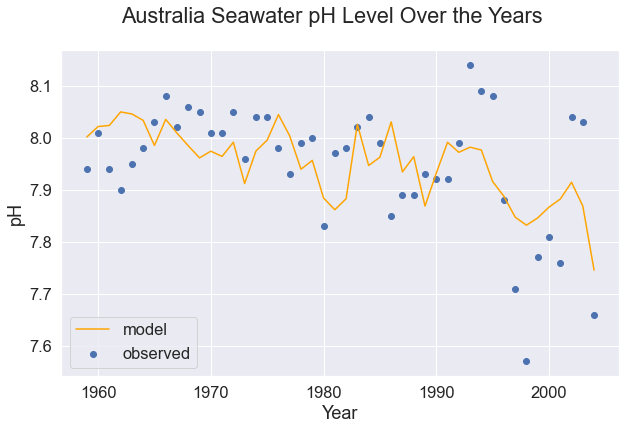

In [48]:
plt.scatter(x = df_ph_co2_mean.index, y = df_ph_co2_mean["pH"], label = "observed")
plt.plot(df_ph_co2_mean.index, y_pred, label = 'model', color = "orange")

plt.suptitle("Australia Seawater pH Level Over the Years")
plt.xlabel("Year")
plt.ylabel("pH")
plt.legend()
plt.gcf().set_size_inches(10, 6)

In [21]:
# set year as index, comment out so that do not receive errors upon running more than once

df_ph_co2_mean.set_index("Year", inplace=True)

In [60]:
# create new dataframe with same values as df_ph_co2_mean
df_ph_predicted = pd.DataFrame(df_ph_co2_mean)


# predict until 2050 and append to df_ph_predicted

for i in range(2005, 2051):
    
    # calculate future pH mean, will always have 5 previous years so no outlier/weird calculations
    ph_sum = 0
    for idx in range(i - 5, i):
        ph_sum += df_ph_predicted.loc[idx][0]
            
    ph_mean = ph_sum / 5
    
    # plug values into formula to calculate predicted pH
    formula = reg.intercept_ + (reg.coef_[0] * i) + (reg.coef_[1] * df_co2_future.loc[i].values)+ (reg.coef_[2] * ph_mean)
     
    # add as new row to dataframe
    df_ph_predicted.loc[i] = {"pH" : formula[0],
                              "CO2 emissions (MtC)" : df_co2_future.loc[i].values[0],
                              "pH mean" : ph_mean}

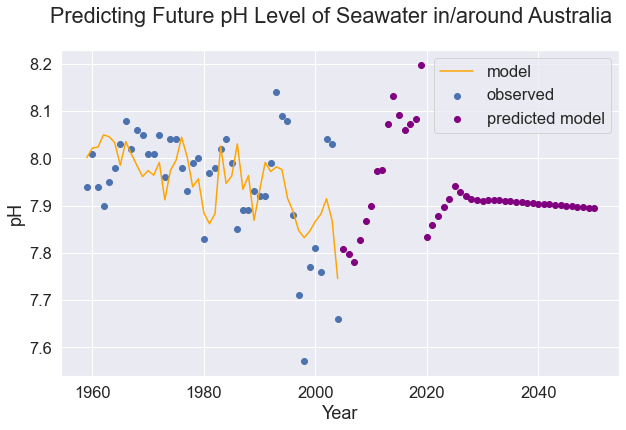

In [61]:
plt.scatter(x = df_ph_co2_mean.index, y = df_ph_co2_mean["pH"], label = "observed")
plt.plot(df_ph_co2_mean.index, y_pred, label = 'model', color = "orange")

# boolean series to extract future data
future_series = df_ph_predicted.index.values > 2004
df_future_years = df_ph_predicted.iloc[future_series]

plt.scatter(x=df_future_years.index, y = df_future_years['pH'], label = 'predicted model', color = 'purple')

plt.suptitle("Predicting Future pH Level of Seawater in/around Australia")
plt.xlabel("Year")
plt.ylabel("pH")
plt.legend()
plt.gcf().set_size_inches(10, 6)

In [62]:
df_ph_future = pd.DataFrame(df_ph_predicted)
df_ph_future.head()

,pH,CO2 emissions (MtC),pH mean
Year,,,
1959,7.94,23.0,7.940000
1960,8.01,24.0,7.940000
1961,7.94,25.0,7.975000
1962,7.90,26.0,7.963333
1963,7.95,28.0,7.947500
